# Some Typical Financial Calculations

This notebook (a) estimates CAPM equations and autocorrelations; (b) implements a simple trading strategy; (c) calculates Value at Risk using a simple model for time-varying volatility; (d) calculates the Black-Scholes option price and implied volatility; (e) calculates and draws the mean-variance frontier (w/w.o short selling restrictions).

## Load Packages and Extra Functions

The [Roots](https://github.com/JuliaMath/Roots.jl) package solves non-linear equations and the [StatsBase](https://github.com/JuliaStats/StatsBase.jl) package has methods for estimating autocorrelations etc.

In [1]:
using Printf, Dates, DelimitedFiles, LinearAlgebra, Roots, Distributions, StatsBase

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))        #use pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Load Data

In [3]:
x   = readdlm("Data/MyData.csv",',',skipstart=1)        #monthly return data
ym  = round.(Int,x[:,1])     #yearmonth, like 200712
Rme = x[:,2]                 #market excess return
Rf  = x[:,3]                 #interest rate
R   = x[:,4]                 #return small growth stocks
Re  = R - Rf                 #excess returns
T   = size(Rme,1)

dN = Date.(string.(ym),"yyyymm")  #convert to string and then Julia Date
printmat([dN[1:4] Re[1:4] Rme[1:4]])

1979-01-01    10.190     4.180
1979-02-01    -2.820    -3.410
1979-03-01    10.900     5.750
1979-04-01     2.470     0.050



# CAPM

The CAPM regression is

$R_{it}^{e}  =\alpha_{i}+\beta_{i}R_{mt}^{e}+\varepsilon_{it}$,

where $R_{it}^{e}$ is the excess return of asset $i$ and $R_{mt}^{e}$ is the market excess return. Theory says that $\alpha=0$, which is easily tested.

In [4]:
x    = [ones(T) Rme]             #regressors
y    = copy(Re)                  #to get standard OLS notation
b    = x\y                       #OLS
u    = y - x*b                   #residuals
covb = inv(x'x)*var(u)           #cov(b), see any textbook
stdb = sqrt.(diag(covb))         #std(b)
R2   = 1 - var(u)/var(y)

printmat([b stdb b./stdb],colNames=["coeff","std","t-stat"],rowNames=["α","β"])
printlnPs("R2: ",R2)
printlnPs("no. of observations: ",T)

      coeff       std    t-stat
α    -0.504     0.304    -1.656
β     1.341     0.066    20.427

      R2:      0.519
no. of observations:    388    


# Return Autocorrelation

That is, the correlation of $R_{t}^{e}$ and $R_{t-s}^{e}$. 

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation.

In [5]:
plags = 1:5
xCorr = autocor(Re,plags)         #using the StatsBase package

println("Autocorrelations (different lags) of the excess returns in Re")
printmat([xCorr sqrt(T)*xCorr],colNames=["autocorr","t-stat"],rowNames=string.(plags),cell00="lag")

Autocorrelations (different lags) of the excess returns in Re
lag  autocorr    t-stat
1       0.216     4.253
2       0.002     0.046
3      -0.018    -0.359
4      -0.065    -1.289
5      -0.027    -0.536



# A Trading Strategy

The next cell implements a very simple momentum trading strategy. 

1. If $R_{t-1}^{e}\ge0$, then we hold the market index and shorten the riskfree from $t-1$ to $t$. This means that we will earn $R_{t}^{e}$.

2. Instead,  if $R_{t-1}^{e}<0$, then we do the opposite. This means that we will earn $-R_{t}^{e}$. 

This simple strategy could be coded without using a loop, but "vectorization" does not speed up much. 

In [6]:
(w,Rp)  = (fill(NaN,T),fill(NaN,T))
for t = 2:T
  w[t]  = (Re[t-1] < 0)*(-1) + (Re[t-1] >= 0)*1       #w is -1 or 1
  Rp[t] = w[t]*Re[t] 
end

μ = [mean(Rp[2:end]) mean(Re[2:end])]
σ = [std(Rp[2:end])  std(Re[2:end])]

printlnPs("The annualized mean excess return of the strategy and a passive portfolio are: ",μ*12)
printlnPs("The annualized Sharpe ratios are: ",sqrt(12)*μ./σ)

The annualized mean excess return of the strategy and a passive portfolio are:     26.733     3.329
The annualized Sharpe ratios are:      0.932     0.112


# Value at Risk

The next cell constructs an simple estimate of $\sigma_t^2$ as a backward looking moving average (the RiskMetrics approach):

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1} -\mu)^2$,
where $\mu$ is the average return (for all data).

Then, we calculate the 95% VaR by assuming a $N(\mu,\sigma_t^2)$ distribution:

$\textrm{VaR}_{t} = - (\mu-1.64\sigma_t)$.

If the model is correct, then $-R_t > \text{VaR}_{t}$ should only happen 5% of the times.

In [7]:
μ = mean(Rme)

λ = 0.95                         #weight on old volatility
σ² = fill(var(Rme),T)            #RiskMetrics approach to estimate variance
for t = 2:T
  σ²[t] = λ*σ²[t-1] + (1-λ)*(Rme[t-1]-μ)^2
end

VaR95 = -(μ .- 1.64*sqrt.(σ²));      #VaR at 95% level

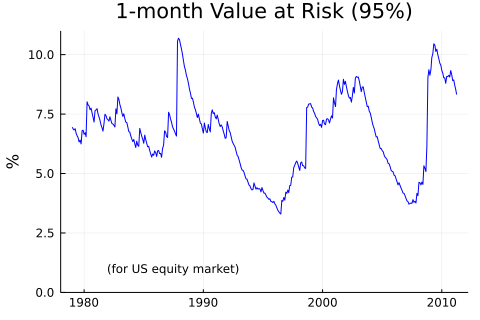

In [8]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,VaR95,
           color = :blue,
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           ylim = (0,11),
           title = "1-month Value at Risk (95%)",
           ylabel = "%",
           annotation = (Date(1982),1,text("(for US equity market)",8,:left)) )
display(p1)

# Options

## Black-Scholes Option Price

Let $S$ be the the current spot price of an asset and $y$ be the interest rate.

The Black-Scholes formula for a European call option with strike price $K$ and time to expiration $m$ is

$C  =S\Phi(d_{1})  -e^{-ym}K\Phi(d_{2})$, where

$d_{1} =\frac{\ln(S/K)+(y+\sigma^{2}/2)m}{\sigma\sqrt{m}} \ \text{ and } \ d_{2}=d_{1}-\sigma\sqrt{m}$ 

and where $\Phi(d)$ denotes the probability of $x\leq d$ when $x$ has an $N(0,1)$ distribution. All variables except the volatility ($\sigma$) are directly observable. 

In [9]:
"""
Pr(z<=x) for N(0,1)
"""
Φ(x) = cdf(Normal(0,1),x)     #a one-line function

"""
Calculate Black-Scholes european call option price
"""
function OptionBlackSPs(S,K,m,y,σ)

  d1 = ( log(S/K) + (y+1/2*σ^2)*m ) / (σ*sqrt(m))
  d2 = d1 - σ*sqrt(m)
  c  = S*Φ(d1) - exp(-y*m)*K*Φ(d2)
  return c
end

OptionBlackSPs

In [10]:
σ = 0.4
c1 = OptionBlackSPs(10,10,0.5,0.1,σ)
printlnPs("\n","call price according to Black-Scholes: ",c1)

K = range(7,stop=13,length=51)
c = OptionBlackSPs.(10,K,0.5,0.1,σ);

         
call price according to Black-Scholes:      1.358


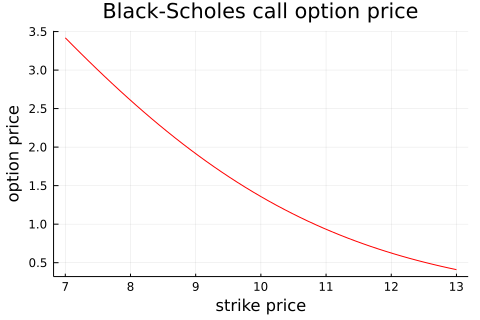

In [11]:
p1 = plot( K,c,
           color = :red,
           legend = false,
           title = "Black-Scholes call option price",
           xlabel = "strike price",
           ylabel = "option price" )
display(p1)

# Implied Volatility

is the $\sigma$ value that makes the Black-Scholes equation give the same option price as observed on the market. It is often interpreted as the "market uncertainty."

The next cell uses the call option price calculated above as the market price. The implied volatility should then equal the volatility used above (this is a way to check your coding).

The next few cells instead use some data on options on German government bonds. 

In [12]:
                                #solve for implied vol
iv = find_zero(σ->OptionBlackSPs(10,10,0.5,0.1,σ)-c1,(0.00001,5))

printlnPs("Implied volatility: ",iv,", compare with: $σ")

Implied volatility:      0.400, compare with: 0.4


In [13]:
#  LIFFE Bunds option data, trade date April 6, 1994
K = [                        #strike prices; Mx1 vector
      92.00;  94.00;  94.50;  95.00;  95.50;  96.00;  96.50;  97.00;
      97.50;  98.00;  98.50;  99.00;  99.50;  100.0;  100.5;  101.0;
     101.5;  102.0;  102.5;  103.0;  103.5 ];
C = [                        #call prices; Mx1 vector
      5.13;    3.25;    2.83;    2.40;    2.00;    1.64;    1.31;    1.02;
      0.770;   0.570;   0.400;   0.280;   0.190;   0.130;  0.0800;  0.0500;
      0.0400;  0.0300;  0.0200;  0.0100;  0.0100 ];
S = 97.05                #spot price
m = 48/365               #time to expiry in years
y = 0.0                  #Interest rate: LIFFE=>no discounting
N = length(K)

21

In [14]:
iv = fill(NaN,N)       #looping over strikes
for i = 1:N
  iv[i] = find_zero(sigma->OptionBlackSPs(S,K[i],m,y,sigma)-C[i],(0.00001,5))
end

println("Strike and iv for data: ")
printmat([K iv])

Strike and iv for data: 
    92.000     0.094
    94.000     0.081
    94.500     0.081
    95.000     0.078
    95.500     0.075
    96.000     0.074
    96.500     0.072
    97.000     0.071
    97.500     0.070
    98.000     0.069
    98.500     0.068
    99.000     0.067
    99.500     0.067
   100.000     0.068
   100.500     0.067
   101.000     0.067
   101.500     0.070
   102.000     0.073
   102.500     0.074
   103.000     0.072
   103.500     0.077



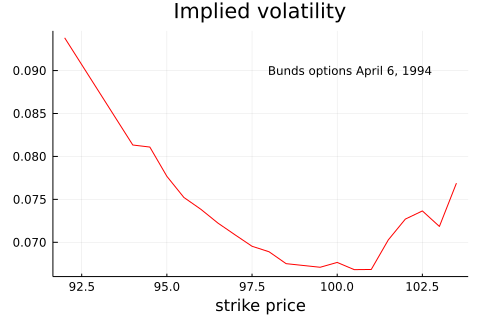

In [15]:
p1 = plot( K,iv,
           color = :red,
           legend =false,
           title = "Implied volatility",
           xlabel = "strike price",
           annotation = (98,0.09,text("Bunds options April 6, 1994",8,:left)) )
display(p1)

# Mean-Variance Frontier

Given a vector of average returns ($\mu$) and a variance-covariance matrix ($\Sigma$), the mean-variance frontier shows the lowest possible portfolio uncertainty for a given expected portfolio return (denoted $\mu\text{star}$ below).

It is thus the solution to a quadratic minimization problem. The cells below will use the explicit (matrix) formulas for this solution, but we often have to resort to numerical methods when there are portfolio restrictions.

It is typically plotted with the portfolio standard deviation on the horizontal axis and the portfolio expected return on the vertical axis.

We calculate and plot two different mean-variance frontiers: (1) when we only consider risky assets; (2) when we also consider a risk-free asset.

In [16]:
μ = [11.5, 9.5, 6]/100          #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2
Rf = 0.03                       #riskfree return (an interest rate)

println("μ: ")
printmat(μ)
println("Σ: ")
printmat(Σ)
println("Rf: ")
printmat(Rf)

μ: 
     0.115
     0.095
     0.060

Σ: 
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

Rf: 
     0.030



In [17]:
"""
    MVCalc(μstar,μ,Σ)

Calculate the std and weights of a portfolio (with mean return μstar) on MVF of risky assets.

# Input
- `μstar::Vector`:    K vector, mean returns to calculate results for
- `μ::Vector`:        n vector, mean returns
- `Σ::Matrix`:        nxn, covariance matrix of returns, can contain riskfree assets

# Output
- `StdRp::Vector`:    K vector, standard deviation of mean-variance portfolio (risky only) with mean μstar
- `w_p::Matrix`:      Kxn, portfolio weights of       ""

"""
function MVCalc(μstar,μ,Σ)

    (K,n) = (length(μstar),length(μ))

    Σ_1  = inv(Σ)
    a    = μ'Σ_1*μ
    b    = μ'Σ_1*ones(n)
    c    = ones(n)'Σ_1*ones(n)

    (w_p,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i = 1:K
        λ        = (c*μstar[i] - b)/(a*c-b^2)
        δ        = (a-b*μstar[i])/(a*c-b^2)
        w        = Σ_1 *(μ*λ.+δ)
        StdRp[i] = sqrt(w'Σ*w)
        w_p[i,:] = w
    end

    return StdRp,w_p

end


"""
Calculate the std of a portfolio (with mean μstar) on MVF of (Risky,Riskfree)
"""
function MVCalcRf(μstar,μ,Σ,Rf)

    (K,n) = (length(μstar),length(μ))

    μᵉ    = μ .- Rf                 #expected excess returns
    Σ_1   = inv(Σ)

    (w_p,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i = 1:K
        w        = (μstar[i]-Rf)/(μᵉ'Σ_1*μᵉ) * Σ_1*μᵉ
        StdRp[i] = sqrt(w'Σ*w)
        w_p[i,:] = w
    end

    return StdRp,w_p

end

MVCalcRf

In [18]:
μstar = range(Rf,stop=0.15,length=201)
L     = length(μstar)

StdRp = MVCalc(μstar,μ,Σ)[1]    #risky assets only, [1] to get the first output
println()

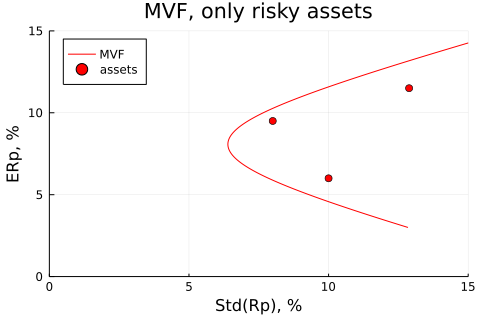

In [19]:
p1 = plot( StdRp*100,μstar*100,
           linecolor = :red,
           xlim = (0,15),
           ylim = (0,15),
           label = "MVF",
           legend = :topleft,
           title = "MVF, only risky assets",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

In [20]:
StdRpRf = MVCalcRf(μstar,μ,Σ,Rf)[1]         #with riskfree too
println()

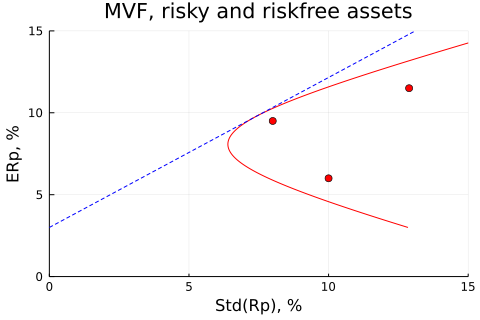

In [21]:
p1 = plot( [StdRp StdRpRf]*100,[μstar μstar]*100,
           legend = nothing,
           linestyle = [:solid :dash],
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF, risky and riskfree assets",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red)
display(p1)

# Mean-Variance Frontier without Short Selling (extra)

The code below solves (numerically) the following minimization problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we also require $w_i\ge 0$ and $\sum_{i=1}^{n}w_{i}=1$.

To solve this, we use the packages [Convex.jl](https://github.com/jump-dev/Convex.jl) (for the interface) and [SCS.jl](https://github.com/jump-dev/SCS.jl) (for the optimization algorithm). To check for convergence, we also need a function from the [MathOptInterface.jl](https://github.com/jump-dev/MathOptInterface.jl) package.

In [22]:
using Convex, SCS
import MathOptInterface
const MOI = MathOptInterface

MathOptInterface

In [23]:
"""
    MeanVarNoSSPs(μ,Σ,μstar)

Calculate mean variance frontier when short sales are not allowed, using Convex and SCS


# Input
- `μ::Vector`:        n vector, mean returns
- `Σ::Matrix`:        nxn, covariance matrix of returns, can contain riskfree assets
- `μstar::Vector`:    K vector, mean returns to calculate results for

# Output
- `StdRp::Vector`:    K vector, standard deviation of mean-variance portfolio (risky only) with mean μstar
- `w_p::Matrix`:      Kxn, portfolio weights of       ""

# Requires
- Convex and SCS

"""
function MeanVarNoSSPs(μ,Σ,μstar)   #MV with no short-sales, numerical minimization

    (K,n) = (length(μstar),length(μ))

    n    = length(μ)
    vv   = findall( minimum(μ) .<= μstar .<= maximum(μ) )  #solve only if feasible

    w    = Variable(n)
    Varp = quadform(w,Σ)
    c1   = sum(w) == 1
    c3   = 0 <= w                    #replace 0 and 1 to get other restrictions
    c4   = w <= 1

    (w_p,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i in vv         #loop over (feasible) μstar elements
        c2      = dot(w,μ) == μstar[i]
        problem = minimize(Varp,c1,c2,c3,c4)
        Convex.solve!(problem,()->SCS.Optimizer(verbose=false))
        if problem.status == MOI.OPTIMAL        #check if solution has been found
            w_p[i,:] = evaluate(w)
            StdRp[i] = sqrt(evaluate(Varp))
        end
    end

    return StdRp, w_p

end

MeanVarNoSSPs

In [24]:
Std_no_ss = MeanVarNoSSPs(μ,Σ,μstar)[1]
println()

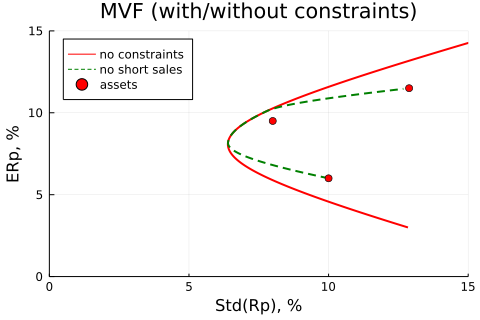

In [25]:
p1 = plot( [StdRp Std_no_ss]*100,[μstar μstar]*100,
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           linewidth = 2, 
           label = ["no constraints" "no short sales"],
           xlim = (0,15),
           ylim = (0,15),
           legend = :topleft,
           title = "MVF (with/without constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)